In [73]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import h5py
import tqdm.notebook
import sklearn.metrics
import matplotlib.pyplot as plt

In [32]:
data = {
    'eplus': h5py.File('data/eplus_angle_position_5deg_xy.h5'),
    'piplus': h5py.File('data/piplus_angle_position_5deg_xy.h5'),
    'gamma': h5py.File('data/gamma_angle_position_5deg_xy.h5'),
}

In [45]:
dev = torch.device('cuda')

In [58]:
from typing import Tuple, Optional

def sample_sizes(size_a: int, size_b: int, num_samples: int) -> Tuple[int, int]:
    num_a_samples = min(
        np.random.binomial(num_samples, size_a / (size_a + size_b)),
        size_a,
    )
    num_b_samples = min(num_samples - num_a_samples, size_b)
    assert num_a_samples <= size_a
    assert num_b_samples <= size_b
    return num_a_samples, num_b_samples

class SamplerEpoch:
    def __init__(
        self,
        num_a_indices: int,
        num_b_indices: int,
        minibatch_size: int,
        id: Optional[int],
        cursor_a: int = 0,
        cursor_b: int = 0
    ) -> None:
        self.minibatch_size = minibatch_size
        self.id = id
        self.num_a_indices = num_a_indices
        self.num_b_indices = num_b_indices
        self.initial_cursor_a = cursor_a
        self.initial_cursor_b = cursor_b
        self.cursor_a = cursor_a
        self.cursor_b = cursor_b
    
    def __iter__(self) -> 'SamplerEpoch':
        return self

    def __next__(self):
        num_a_items_left = self.num_a_indices - self.cursor_a
        num_b_items_left = self.num_b_indices - self.cursor_b
        assert num_a_items_left >= 0
        assert num_b_items_left >= 0
        
        if num_a_items_left == num_b_items_left == 0:
            raise StopIteration()

        num_a_items, num_b_items = sample_sizes(
            num_a_items_left,
            num_b_items_left,
            self.minibatch_size,
        )
        
        begin_a = self.cursor_a
        end_a = begin_a + num_a_items
        begin_b = self.cursor_b
        end_b = begin_b + num_b_items
        
        self.cursor_a = end_a
        self.cursor_b = end_b
        return (begin_a, end_a), (begin_b, end_b)
    
    def __len__(self):
        num_indices = self.num_a_indices + self.num_b_indices - self.initial_cursor_a - self.initial_cursor_b
        batch = self.minibatch_size
        return (num_indices + batch - 1) // batch
    
    def __repr__(self) -> str:
        return (
            f'SamplerEpoch(id={self.id}), '
            f'minibatch_size={self.minibatch_size}, '
            f'num_indices=({self.num_a_indices}, {self.num_b_indices}), '
            f'cursor=({self.cursor_a}, {self.cursor_b}))'
        )

class Sampler:
    def __init__(
        self,
        num_samples_a: int,
        num_samples_b: int,
        minibatch_size: int,
        cv_split: float,
    ) -> None:
        num_cv_indices_a = round(num_samples_a * cv_split)
        num_cv_indices_b = round(num_samples_b * cv_split)
        self.cv_start_a = num_samples_a - num_cv_indices_a
        self.cv_start_b = num_samples_b - num_cv_indices_b
        self.num_samples_a = num_samples_a
        self.num_samples_b = num_samples_b
        self.minibatch_size = minibatch_size
        self.num_epochs = 0
    
    def epoch(self) -> SamplerEpoch:
        self.num_epochs += 1
        return SamplerEpoch(
            self.cv_start_a,
            self.cv_start_a,
            minibatch_size=self.minibatch_size,
            id=self.num_epochs,
        )
    
    def cv(self) -> SamplerEpoch:
        return SamplerEpoch(
            self.num_samples_a,
            self.num_samples_b,
            minibatch_size=self.minibatch_size,
            id=None,
            cursor_a=self.cv_start_a,
            cursor_b=self.cv_start_b,
        )

    def __repr__(self) -> str:
        return (
            f'Sampler(cv_start=({self.cv_start_a}, {self.cv_start_b}), '
            f'num_samples=({self.num_samples_a}, {self.num_samples_b}), '
            f'minibatch_size={self.minibatch_size}, '
            f'self.num_epochs={self.num_epochs})'
        )

In [84]:
def flatten_layers(data_file, begin, end) -> np.ndarray:
    layers = []
    for i in range(3):
        layer = data_file[f'layer_{i}']
        feature_size = 1
        for x in layer.shape[1:]:
            feature_size *= x
        layer_part = layer[begin:end]
        layers.append(layer_part.reshape((layer_part.shape[0], feature_size)))
    return np.hstack(layers)

def prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b, device=None):
    if device is None:
        device = dev
    x_a = flatten_layers(data_a, begin_a, end_a)
    x_b = flatten_layers(data_b, begin_b, end_b)
    x = torch.Tensor(np.vstack([x_a, x_b])).to(device)
    y = torch.Tensor([0] * (end_a - begin_a) + [1] * (end_b - begin_b)).to(device)
    return x, y

In [91]:
class ModelFcPixel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            self.make_layer(504, 512),
            self.make_layer(512, 1024),
            self.make_layer(1024, 2048),
            self.make_layer(2048, 1024),
            self.make_layer(1024, 128),
            torch.nn.Linear(128, 1),
            torch.nn.Sigmoid(),
        )
    
    @staticmethod
    def make_layer(num_in, num_out):
        return torch.nn.Sequential(
            torch.nn.Linear(num_in, num_out),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(),
            torch.nn.BatchNorm1d(num_out),
        )
        
    def forward(self, x):
        return self.layers(x)

In [108]:
def train_and_evaluate(
    model,
    alt_label,
    num_epochs,
    minibatch_size=128,
    cv_split=0.1,
):
    data_a = data['eplus']
    data_b = data[alt_label]
    sampler = Sampler(
        len(data_a['layer_0']),
        len(data_b['layer_0']),
        minibatch_size=minibatch_size,
        cv_split=cv_split,
    )
    opt = torch.optim.Adam(model.parameters(), lr=0.0001)
    
    max_train_index_a = 0
    max_train_index_b = 0
    model.train()
    while True:
        epoch = sampler.epoch()
        if epoch.id > 2:
            break

        print(f'==> Epoch {epoch.id}', flush=True)
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(epoch):
            assert begin_a <= end_a
            assert begin_b <= end_b
            max_train_index_a = max([max_train_index_a, end_a-1])
            max_train_index_b = max([max_train_index_b, end_b-1])
            opt.zero_grad()
            x, y = prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            y_prob = model(x).flatten()
            loss = F.binary_cross_entropy(y_prob, y)
            loss.backward()
            opt.step()
    
    model.eval()

    y = []
    y_prob = []
    with torch.no_grad():
        for (begin_a, end_a), (begin_b, end_b) in tqdm.notebook.tqdm(sampler.cv()):
            assert max_train_index_a < begin_a <= end_a
            assert max_train_index_b < begin_b <= end_b
            x, this_y = prepare_input(data_a, data_b, begin_a, end_a, begin_b, end_b)
            this_y_prob = model(x).flatten().cpu()
            y += list(this_y.cpu())
            y_prob += list(this_y_prob)
    
    return model, y, y_prob

In [109]:
models = [
    ModelFcPixel().to(dev),
]
num_epochs = 2
alt_label = 'piplus'

results = {}
for model in models:
    _, y, y_prob = train_and_evaluate(
        model=model,
        alt_label=alt_label,
        num_epochs=num_epochs,
    )
    results[model.__class__.__name__] = (y, y_prob)

==> Epoch 1


  0%|          | 0/5625 [00:00<?, ?it/s]

==> Epoch 2


  0%|          | 0/5625 [00:00<?, ?it/s]

  0%|          | 0/704 [00:00<?, ?it/s]

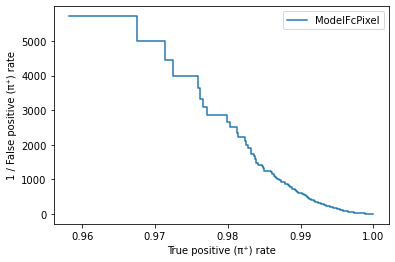

In [111]:
fpr_threshold = 1/6000
tpr_threshold = 0.9

labels = []
handles = []

for name, (y, y_prob) in results.items():
    fpr, tpr, _ = sklearn.metrics.roc_curve(y, y_prob)
    mask = (fpr > fpr_threshold) & (tpr > tpr_threshold)
    handles += plt.plot(tpr[mask], 1/fpr[mask])
    labels.append(name)

plt.xlabel('True positive (π⁺) rate')
plt.ylabel('1 / False positive (π⁺) rate')
plt.legend(handles=handles, labels=labels)
plt.show()